<a href="https://colab.research.google.com/github/PhD-Gabriel-Caballero/ESA-summer-school-2023-Croatia/blob/main/Unsupervised_land_cover_classification_based_on_S1_time_series_using_machine_learning_algorithms_in_GEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Unsupervised land cover classification based on S1 time series using machine learning algorithms in GEE

---

This Jupyter notebook contains all the necessary information for land cover unsupervised classification based on Sentinel-1 time series in the Google Earth (GEE) cloud computing platform. This material has been created exclusively for the 2023 European Space Agency (ESA) summer school.

---

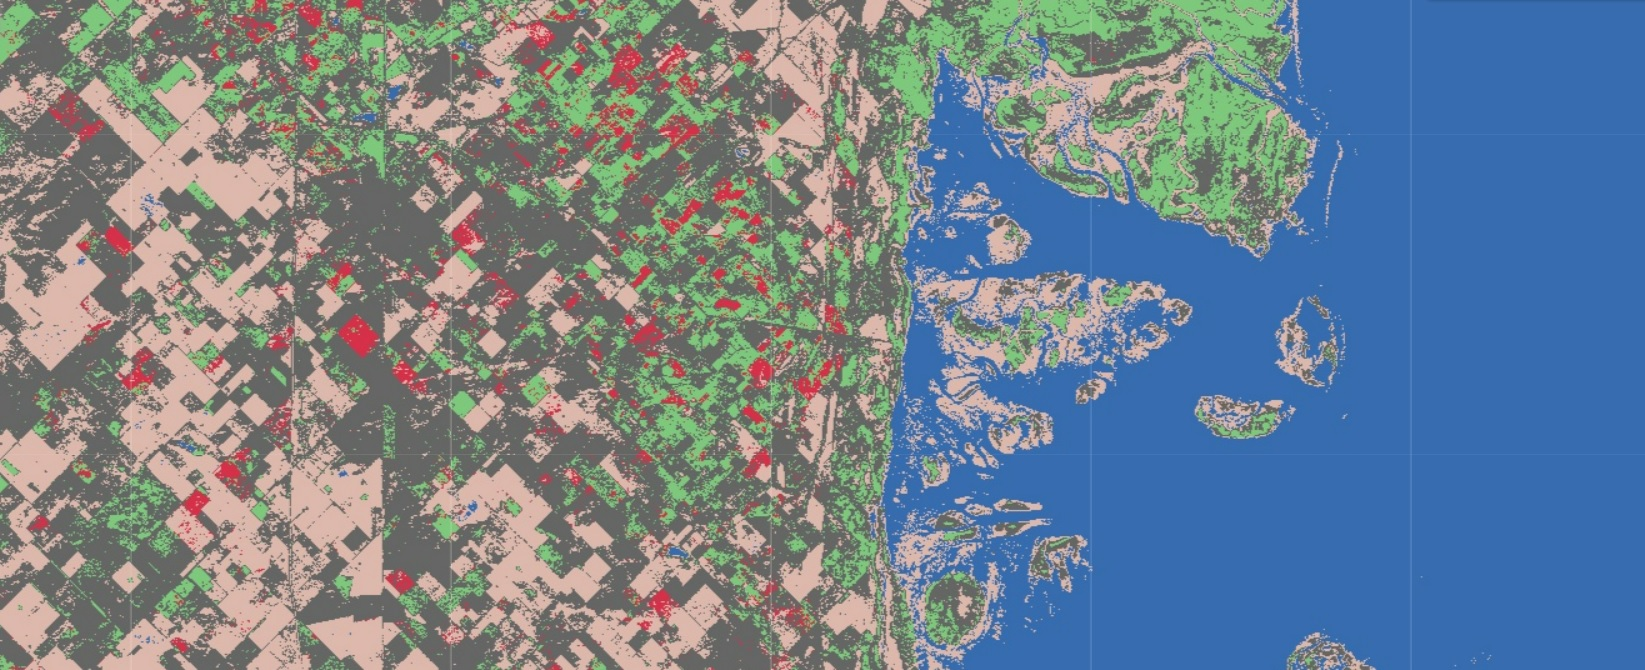

In this study, we investigate the use of S1 time series for thematic crop mapping in a South Argentinian valley. SAR data, while not optimal for vegetation classification, is advantageous as it is not affected by cloud cover.

This area comprises vast agricultural fields with well-defined crops and flat terrain, which is a significant advantage for SAR measurement.

---

Credits and references


Original source code:
[Machine Learning with Earth Engine - Unsupervised Classification](https://geemap.org/notebooks/31_unsupervised_classification/)

[1] Caballero, G.R.; Platzeck, G.; Pezzola, A.; Casella, A.; Winschel, C.; Silva, S.S.; Ludueña, E.; Pasqualotto, N.; Delegido, J. Assessment of Multi-Date Sentinel-1 Polarizations and GLCM Texture Features Capacity for Onion and Sunflower Classification in an Irrigated Valley: An Object Level Approach. Agronomy 2020, 10, 845. https://doi.org/10.3390/agronomy10060845

In [ ]:
!pip install geemap
!pip install PyCRS

**Import libraries**

In [135]:
from google.colab import output
output.enable_custom_widget_manager()

import ee
import geemap
import sys
import  pycrs
import geemap.colormaps as cm

**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Clone the GitHub repository**

In [137]:
!rm -r ESA-summer-school-2023-Croatia # delete the complete repository folder
!git clone https://github.com/PhD-Gabriel-Caballero/ESA-summer-school-2023-Croatia # clone repository folder
sys.path.insert(0,'/content/ESA-summer-school-2023-Croatia')

Cloning into 'ESA-summer-school-2023-Croatia'...
remote: Enumerating objects: 269, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 269 (delta 168), reused 116 (delta 80), pack-reused 53
Receiving objects: 100% (269/269), 36.00 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (179/179), done.


**To use the Earth Engine API on the GEE cloud platform, import ee and geemap, and then log in to authenticate**

In [138]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

**Define and visualize the study area**

In [217]:
# Set map display properties.
Map = geemap.Map(toolbar_ctrl=True, layer_ctrl=True)
Map.default_style = {'cursor': 'crosshair'}
Map.add_basemap('SATELLITE')

# Center the map in the desired country
country = 'Argentina'
country_bounds = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filterMetadata('country_na', 'equals', country);
Map.centerObject(country_bounds,6)
Map

Map(center=[-34.687845828472675, -64.74963675588427], controls=(WidgetControl(options=['position', 'transparen…

**Show the Region Of Interest (ROI) in the interactive map**

In [140]:
# Please provide here the information on the experimental station and the boundaries of your crop essay.
wheat_roi = geemap.shp_to_ee('/content/ESA-summer-school-2023-Croatia/Vectors/Wheat trial sketch 2020/wheat trial sketch 2020.shp')
EEHA_roi = geemap.shp_to_ee('/content/ESA-summer-school-2023-Croatia/Vectors/EEHA boundaries/INTA EEHA subdivision 2020.shp')
wheat_insitu_points =  geemap.shp_to_ee('/content/ESA-summer-school-2023-Croatia/Vectors/Wheat sampling points 2020/wheat_sampling_points_2020.shp')
wheat_insitu_points_insitu_data_2020 = geemap.shp_to_ee('/content/ESA-summer-school-2023-Croatia/Vectors/Wheat sampling points 2020/wheat_sampling_points_insitu_data_2020.shp')

Map.addLayer(wheat_roi, {},'Wheat roi 2020',True, opacity = 0.3)
Map.addLayer(wheat_insitu_points, {},'Wheat insitu points 2020',True)
Map.addLayer(EEHA_roi, {},'Study area',True, opacity = 0.5)

**Retrieve the ROI from the map for classifier training**

In [141]:
training_region = Map.user_roi #Draw a shape (e.g., rectangle) on the map

**Funtions definition**

In [142]:
#Function to convert from dB
def toNatural(img):
    return ee.Image(10.0).pow(img.select(0).divide(10.0))

#Function to convert to dB
def todB(img):
    return ee.Image(img).log10().multiply(10.0)

In [197]:
# Clipping image collection by geometry
def clipcol(image):
    clipimage = image.clip(EEHA_roi)
    return clipimage

**Dates of interest and acquisitions configuration parameters**

In [144]:
# Configuration Parameters
start_date = '2019-02-01'
end_date = '2020-02-01'

# Select the current region of interest
roi_center_lat = -39.400633
roi_center_lon = -62.639496

roi_point = ee.Geometry.Point([roi_center_lon, roi_center_lat])

**Create the initial image collection with the polarimetric SAR bands**

In [145]:
# Retrieving Sentinel 1 imagery
print('SENTINEL1 time series being retrieved')
S1collection = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')\
                     .filterBounds(roi_point)\
                     .filterDate(start_date, end_date)\
                     .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
                     .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
                     .filter(ee.Filter.eq('instrumentMode', 'IW'))\
                     .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
                     .filter(ee.Filter.eq('resolution','H'))\
                     .select('VH','VV')\

# Sort the dataset S1
S1collection = S1collection.sort('GRD_Post_Processing_start');

SENTINEL1 time series being retrieved


In [201]:
# Filter S1 collection by Relative Orbit Number or Path 68 and satellite S1-A
S1Acollection_P68  =  S1collection.filter(ee.Filter.eq('relativeOrbitNumber_start',68)).filter(ee.Filter.eq('platform_number','A'))

# Polarization filtering
S1Acollection_P68_VH  = ee.ImageCollection(S1Acollection_P68.select(["VH"])).map(todB)
S1Acollection_P68_VV  = ee.ImageCollection(S1Acollection_P68.select(["VV"])).map(todB)

# From GEE image collection to one image containing multiple bands
image_S1_VH = S1Acollection_P68_VH.toBands(); # S1 VH polarization
image_S1_VV = S1Acollection_P68_VV.toBands(); # S1 VV polarization

image_S1 = S1Acollection_P68.toBands(); # S1 VH&VV polarization

**Make training dataset**

In [210]:
# Make the training dataset.
training = image_S1_VH.sample(
    **{
        'region': training_region, #If you do not define a region, it will use the image footprint by default
        'scale': 10,
        'numPixels': 5000,
        'seed': 5,
        'geometries': True,  # Set this to False to ignore geometries
    }
)

In [211]:
map_center_lat = -39.400633
map_center_lon = -62.639496

Map_S1 = geemap.Map()
Map_S1 = geemap.Map(center=(map_center_lat,map_center_lon), zoom=8)
Map_S1.set_plot_options(add_marker_cluster=True)

Map_S1.addLayer(training, {}, 'training', True)
Map_S1

Map(center=[-39.400633, -62.639496], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HB…

**Add data to the map**

In [212]:
vis_VH = cm.get_palette('gray', n_class=10)
vis_VH = {'min': -30, 'max': -15, 'palette': vis_VH}

vis_VV = cm.get_palette('gray', n_class=10)
vis_VV = {'min': -17, 'max': -8, 'palette': vis_VV}

# Image collection display (mean, max or min).

Map_S1.addLayer(S1Acollection_P68_VH.mean(),vis_VH, 'S1 VH collection mean')
Map_S1.addLayer(S1Acollection_P68_VV.mean(),vis_VV, 'S1 VV collection mean')

# On-screen display of color bars

Map_S1.add_colorbar(vis_VH, label="VH [dB]", orientation="horizontal", layer_name="VH color bar", position="topleft", location="bottom")
Map_S1.add_colorbar(vis_VV, label="VV [dB]", orientation="horizontal", layer_name="VV color bar", position="topleft", location="bottom")

**Train the clusterer**

In [213]:
# Instantiate the clusterer and train it.
n_clusters = 7
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)

**Classify the image**

In [214]:
# Cluster the input using the trained clusterer.
result = image_S1_VH.cluster(clusterer)

In [229]:
Map_S1_clusters = geemap.Map()
Map_S1_clusters = geemap.Map(center=(map_center_lat,map_center_lon), zoom=8)
Map_S1_clusters.set_plot_options(add_marker_cluster=True)

# # Display the clusters with random colors.
label_colors = cm.get_palette('Accent', n_class=7)
legend_colors = {'min': 1, 'max': 7, 'palette': label_colors}
#Map_S1_clusters.addLayer(result.randomVisualizer(), {}, 'clusters')
Map_S1_clusters.addLayer(result, {'min': 1, 'max': 5, 'palette': label_colors}, 'Labelled clusters')

Map_S1_clusters

Map(center=[-39.400633, -62.639496], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HB…

**Label the clusters**

In [208]:
legend_keys = ['One', 'Two', 'Three', 'Four', 'ect']
legend_colors = ['#8DD3C7', '#FFFFB3', '#BEBADA', '#FB8072', '#80B1D3']

# Reclassify the map
result = result.remap([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])

Map.addLayer(
    result, {'min': 1, 'max': 5, 'palette': legend_colors}, 'Labelled clusters'
)
Map.add_legend(
    legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright'
)
Map

Map(bottom=649694.0, center=[-39.415507503064795, -62.60353292957485], controls=(WidgetControl(options=['posit…

**Visualize the result**

In [209]:
print('Change layer opacity:')
cluster_layer = Map.layers[-1]
cluster_layer.interact(opacity=(0, 1, 0.1))

Change layer opacity:


Box(children=(FloatSlider(value=1.0, description='opacity', max=1.0),))

**Export the result to Google Drive**

[S1 time series crop classification](https://mortcanty.github.io/src/s1class.html)